In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
PATH_IN = './DATA/MovieSummaries/CharacterDF_post_filtering'

# Import data
characterDF= pd.read_csv(PATH_IN)
display(characterDF)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor Name,Actor age at movie release,Freebase character map,Ethnicity
0,975900,/m/03vyhn,2001-08-24 00:00:00+00:00,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,NaN
1,975900,/m/03vyhn,2001-08-24 00:00:00+00:00,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,NaN
2,975900,/m/03vyhn,2001-08-24 00:00:00+00:00,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,African Americans
3,975900,/m/03vyhn,2001-08-24 00:00:00+00:00,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,NaN
4,975900,/m/03vyhn,2001-08-24 00:00:00+00:00,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
313777,913762,/m/03pcrp,1992-05-21 00:00:00+00:00,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,NaN
313778,913762,/m/03pcrp,1992-05-21 00:00:00+00:00,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,NaN
313779,913762,/m/03pcrp,1992-05-21 00:00:00+00:00,Exegran,NaN,M,NaN,NaN,Hal Cleaveland,NaN,/m/0kr407c,NaN
313780,913762,/m/03pcrp,1992-05-21 00:00:00+00:00,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,NaN


In [3]:
characterDF['Movie release date'] = pd.to_datetime(characterDF['Movie release date'], errors='coerce',utc=True)
characterDF['Actor DOB'] = pd.to_datetime(characterDF['Actor DOB'], errors='coerce',utc=True)
characterDF['Actor age at movie release'] = (characterDF['Movie release date']-characterDF['Actor DOB']).dt.days//365
characterDF['Movie release date'] = characterDF['Movie release date'].dt.year
characterDF['Actor DOB'] = characterDF['Actor DOB'].dt.year

display(characterDF.dropna().groupby('Wikipedia movie ID').count())

,Freebase movie ID,Movie release date,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor Name,Actor age at movie release,Freebase character map,Ethnicity
Wikipedia movie ID,,,,,,,,,,,
3217,2,2,2,2,2,2,2,2,2,2,2
3746,3,3,3,3,3,3,3,3,3,3,3
3837,6,6,6,6,6,6,6,6,6,6,6
3947,3,3,3,3,3,3,3,3,3,3,3
4227,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
36598217,1,1,1,1,1,1,1,1,1,1,1
36619262,1,1,1,1,1,1,1,1,1,1,1
36699915,4,4,4,4,4,4,4,4,4,4,4


# Creation of a pertinent metric to evaluate a pool of movies

#### References

In [4]:
#Reference for USA
usa_ref = {}
usa_ref['par']={'F':100/198.1, 'M':98.1/198.1}   # for 100 women, there are 98.1 men
usa_ref['age']={'F':[0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.05,0.02,0.02], 'M':[0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.05,0.02,0.02]} # Age_min, Age_max, % of men, % of women
#usa_ref['div']=[]
usa_ref['hei']={'F':[0.01,0.01,0.02,0.03,0.04,0.08,0.1,0.13,0.16,0.13,0.1,0.08,0.04,0.03,0.02,0.01,0.01],'M':[0.01,0.01,0.02,0.03,0.04,0.08,0.1,0.13,0.16,0.13,0.1,0.08,0.04,0.03,0.02,0.01,0.01]}

#### Scoring functions

In [5]:
def scoring_function(value, target,p,sigma):
    """ Scoring function.
    
    @arg
        value : value between 0 and 1, given by the pool of movie (e.g. frequency)
        target : corresponding target value between 0 and 1, given by statistic on real world
        p : the higher it is, the longer the plateau near the central value is
        sigma : the higher it is, the stronger the thresholding is
    
    @output
        score : between 0 (if value very far from target) and 1 (if value==target)
                The score is not linearly linked with the diffence |value - target|:
                for instance, the score is about 0.5 if a difference of 15% is observed between value and target.
    """
    
    #100 first centered values of the generalized gaussian (the 50th coefficient is the center and equals 1)
    generalized_gaussian = signal.windows.general_gaussian(101, p=p, sig=sigma)
    discrete_distance_to_the_ref = int(round(value-target, 2)*100)
    generalized_gaussian_index = 50+discrete_distance_to_the_ref
    
    #Handling cases where the index is out of range ('value' too far from 'target')
    if generalized_gaussian_index<0 or generalized_gaussian_index>100:
        generalized_gaussian_index=0
    
    score = generalized_gaussian[generalized_gaussian_index]
    return score


def parity_score(pool, ref=usa_ref['par'], p=1.5, sigma=15):
    
    p_F_ref = ref['F'] # reference value for women proportion
    p_F = pool['Actor gender'].dropna().apply(lambda x: x=="F").mean() #proportion of women in the movie pool
    
    missing=pool['Actor gender'].isna().mean()
    return scoring_function(p_F,p_F_ref,p,sigma), missing
 

def age_score(pool, ref=usa_ref['age'], p=1.5, sigma=5):
    """
    function to evaluate the difference between the age distribution of the actors in the movie
    and the real distribution.

    @arguments
        pool : dataframe containing the pool of movie that will be scored
        ref : tool containing the reference for age distribution
        p : the higher it is, the longer the plateau near the central value is
        sigma : the higher it is, the stronger the thresholding is

    @outputs
        age_sc = unitarized age score evaluation. If equal 1, the distribution is exactly the ref

    """
    # Creation of age ranges
    age_ranges = range(0,80,5)
    Nb_bin = len(age_ranges)
    
    # Separation of the pool depending on the gender
    pool_M = pool[pool["Actor gender"]=='M']
    pool_F = pool[pool["Actor gender"]=='F']
    
    # Recuperation of reference frequencies for each age range depending on the gender
    freq_ref_M = ref['M']
    freq_ref_F = ref['F']
    
    # Computation of movie frequencies for each age range depending on the gender
    cmu_age_M = pool_M['Actor age at movie release'].dropna()
    freq_cmu_M = np.histogram(cmu_age_M, bins = age_ranges, density = True)
    cmu_age_F = pool_F['Actor age at movie release'].dropna()
    freq_cmu_F = np.histogram(cmu_age_F, bins = age_ranges, density = True)
    
    # Computation of each subscore and aggregation
    age_sc_M = 0
    age_sc_F = 0
    weights = [5,5,5,5,1,1,1,1,1,1,5,5,5,5,5,5,5]
    for i in range(Nb_bin-1):
        age_sc_M += scoring_function(freq_cmu_M[0][i],freq_ref_M[i],p,sigma)*weights[i]
        age_sc_F += scoring_function(freq_cmu_F[0][i],freq_ref_F[i],p,sigma)*weights[i]
    age_sc_M = age_sc_M/sum(weights)
    age_sc_F = age_sc_F/sum(weights)
        
    # Recuperation of men proportion in the pool for gender weighting
    p_M = pool['Actor gender'].apply(lambda x: x=="M").mean()
    
    
    missing=pool['Actor age at movie release'].isna().mean()
    
    return p_M*age_sc_M+(1-p_M)*age_sc_F, missing

def rescued_age_score(pool, ref=usa_ref['age'], p=1.5, sigma=5, min_score=0.3, max_score=0.55):
    normalized_score, missing = (age_score(pool,ref,p,sigma)-min_score)/(max_score-min_score)
    return normalized_score, missing

def height_score(pool, ref=usa_ref['hei'],p=1.5,sigma=5):
    """
    function to evaluate the difference between the age distribution of the actors in the movie
    and the real distribution.
    IDEAS : do the histogram area difference, but also penalize too high representation of some ages ?

    @arguments
        pool : dataframe containing the pool of movie that will be scored
        ref : tool containing the reference for age distribution
        p : the higher it is, the longer the plateau near the central value is
        sigma : the higher it is, the stronger the thresholding is

    @outputs
        hei_sc = unitarized height score evaluation.

    """
    # Creation of height ranges
    hei_ranges = range(142,191,3)
    Nb_bin = len(hei_ranges)
    
    # Separation of the pool depending on the gender
    pool_M = pool[pool["Actor gender"]=='M']
    pool_F = pool[pool["Actor gender"]=='F']
    
    # Recuperation of reference frequencies for each height range depending on the gender
    freq_ref_M = ref['M']
    freq_ref_F = ref['F']
    
    # Computation of movie frequencies for each height range depending on the gender
    cmu_hei_M = pool_M['Actor height'].dropna()*100
    freq_cmu_M = np.histogram(cmu_hei_M, bins = hei_ranges, density = True)
    cmu_hei_F = pool_F['Actor height'].dropna()*100
    freq_cmu_F = np.histogram(cmu_hei_F, bins = hei_ranges, density = True)
    
    # Computation of each subscore and aggregation
    hei_sc_M = 0
    hei_sc_F = 0
    weights = [2,2,2,2,1,1,1,1,1,1,2,2,2,2,2,2,2]
    for i in range(Nb_bin-1):
        hei_sc_M += scoring_function(freq_cmu_M[0][i],freq_ref_M[i],p,sigma)
        hei_sc_F += scoring_function(freq_cmu_F[0][i],freq_ref_M[i],p,sigma)
    hei_sc_M = hei_sc_M/sum(weights)
    hei_sc_F = hei_sc_F/sum(weights)
    
    missing=pool['Actor height'].isna().mean()
    
    # Recuperation of men proportion in the pool for gender weighting
    p_M = pool['Actor gender'].apply(lambda x: x=="M").mean()
    
    return p_M*hei_sc_M+(1-p_M)*hei_sc_F, missing

def rescued_height_score(pool, ref=usa_ref['hei'],p=1.5,sigma=5, min_score=0.2, max_score=0.5):
    normalized_score = (height_score(pool,ref,p,sigma)-min_score)/(max_score-min_score)
    return normalized_score

def diversity_score(pool, ref=usa_ref['div']):
    """
    First idea : number of ethnicities/total actor 
    => Not that cool because 1 means every actor comes form a different country
    Second idea : population of each global origin (america, asia, africa...)
    """
    nb_eth = pool.groupby('Ethnicity').count().shape[0]
    nb_act = pool.shape[0]
    missing=pool['Ethnicity'].isna().mean()
    return nb_eth/nb_act, missing


##Weighting of each score for the final aggregation
# standard weights
# Ajouter un truc qui fait qu'on a des poids proportionnels aux drops + incertitudes
par_w = 3
hei_w = 1.5
age_w = 1.5
div_w = 3

st_weights=[par_w, age_w, hei_w, div_w]

def representativeness_score(pool,weights=st_weights, ref=usa_ref):
    """
    Weighting and aggregation of every single score
    IDEA : return all intermediate score to verify coherence
    """
    n=len(weights)
    scores=np.zeros(n)
    missing=np.zeros(n)
    
    scores[0],missing[0] = parity_score(pool,ref['par'])
    scores[1],missing[1] = rescued_age_score(pool,ref['age'])
    scores[2],missing[2] = rescued_height_score(pool,ref['hei'])
    scores[3],missing[3] = diversity_score(pool,ref['div'])
    
    updated_weights=[weights[i]-missing[i] for i in range(n)]
    agg_score = np.dot(weights,scores)/sum(weights)
    final_score = int(agg_score*100)
    
    return final_score

#### Characterization and evaluation of the metric

For the following, our goal is ton construct a metric $S$ to evaluate the representativeness score of a pool of movies $P$. This score should compare statistics from $P$ with references statistics $R$ found on the Internet, based on the following features :
- respect of men and women proportion ($S_{parity}$ subscore)
- age distribution ($S_{age}$ subscore)
- height distribution ($S_{height}$ subscore)
- ethnicity diversity ($S_{div}$ subscore)

Each subscore is rated on a scale $[0,1]$ where $0$ means the studied pool of movie is completely opposed to the reference we want to show, and $1$ is a perfect representation. They are then aggregated and weighted to create $S$, taking entire values between $0$ and $100$. The higher the representativeness score is, the better $P$ statistics approach our reference $R$.

###### Construction of the scoring function $S_{parity}$

The goal of this scoring is to penalize strongly pools of movies where men or women are overrepresented.
It should have the following features :
- The score is normalized between 0 and 1.
- Since the gender column of the CharacterDF contains only 'M' (60%), 'F' (30%) or NaN (10%), we will drop NaN so that in terms of proportion, $p_{F}$+$p_{M}$ =1. Hence, to construct our score function, we can only consider to the distance between the reference women proportion $p_{F}^R$ and the  women proportion of the pool $p_{F}$.
- Movies where there is only women and where there is no women should have a score of $0$.
- Movies where $p_{F}(P)=p_{F}^R$ should have a score of 1.
- The score should not penalize too much small deviation from the target (ie if $|p_{F}(P)-p_{F}^R|<0.05$, $S_{parity}(P)>0.9$)
- It should strongly penalize deviation stronger than $15\%$ (if $|p_{F}-p_{F}^R|>0.15$ then $S_{parity}(P)<0.5$).

Taking all those conditions into account, we propose to use a super-gaussian as $S_{parity}$ function. It depends on two parameters $\sigma$ (controlling the length of the plateau around the mean) and $p$ (controlling the slope of the increasing and decreasing part of the curve).
To set up it, we plot the corresponding functions below :

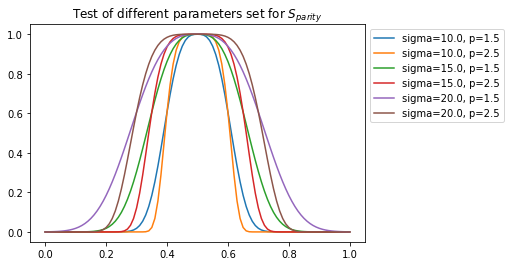

In [6]:
plt.figure()
sigma_list = np.linspace(10.0, 20., 3)  #upper plateau length
p_list      = np.linspace(1.5,  2.5, 2) #slope
for sigma in sigma_list:
    for p in p_list:
        M = 101 #point number
        window = signal.windows.general_gaussian(M, p=p, sig=sigma)
        plt.plot(np.linspace(0,1,M), window, label=f'sigma={round(sigma,2)}, p={round(p, 2)}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Test of different parameters set for $S_{parity}$')
plt.show()

A convenient choice of parameters  is the following : $\sigma=15, p=1.5$.

Testing this score on some pools of movies to assess its performances, we obtain the following results :

In [7]:
#Test datasets
P0 = pd.DataFrame({"Actor gender":['F','M']}) #Parity. Expect 1
P1 = pd.DataFrame({"Actor gender":['F']}) # Only women. Expect almost 0
P2 = pd.DataFrame({"Actor gender":['M']}) # Only men. Expect almost 0
P3 = pd.DataFrame({"Actor gender":['F','M', 'M']}) # 33% women, expect about 0.5
P3 = pd.DataFrame({"Actor gender":['F',np.nan, np.nan]}) # 33% women, expect about 0.5

print(f"The parity score for P0 is : {parity_score(P0)}, "+
      f"and the proportion of women is {P0['Actor gender'].apply(lambda x: x=='F').mean()}\n")
print(f"The parity score for P1 is : {parity_score(P1)}, "+
      f"and the proportion of women is {P1['Actor gender'].apply(lambda x: x=='F').mean()}\n")
print(f"The parity score for P2 is : {parity_score(P2)}, "+
      f"and the proportion of women is {P2['Actor gender'].apply(lambda x: x=='F').mean()}\n")
print(f"The parity score for P3 is : {parity_score(P3)}, "+
      f"and the proportion of women is {P3['Actor gender'].apply(lambda x: x=='F').mean()}\n")

The parity score for P0 is : (1.0, 0.0), and the proportion of women is 0.5

The parity score for P1 is : (9.067959971965017e-09, 0.0), and the proportion of women is 1.0

The parity score for P2 is : (9.067959971965017e-09, 0.0), and the proportion of women is 0.0

The parity score for P3 is : (9.067959971965017e-09, 0.6666666666666666), and the proportion of women is 0.3333333333333333



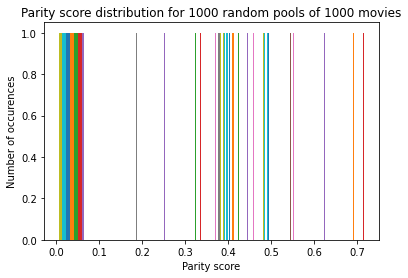

In [8]:
#Test on a large number of random pools of 1000 movies each.
Ntest = 1000
scores_list=[]
for i in range(Ntest):
    P=characterDF.sample(n=1000)
    scores_list.append(parity_score(P))
    
plt.hist(scores_list)
plt.title(f"Parity score distribution for {Ntest} random pools of 1000 movies")
plt.xlabel("Parity score")
plt.ylabel("Number of occurences")
plt.show()

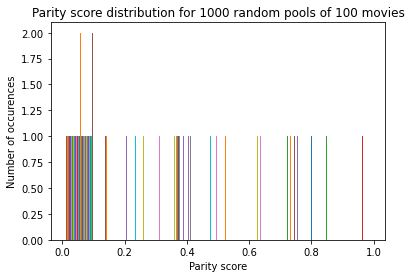

In [9]:
#Test on a large number of random pools of 100 movies each.
scores_list=[]
for i in range(Ntest):
    P=characterDF.sample(n=100)
    scores_list.append(parity_score(P))

plt.hist(scores_list, bins=np.linspace(0,1,10))
plt.title(f"Parity score distribution for {Ntest} random pools of 100 movies")
plt.xlabel("Parity score")
plt.ylabel("Number of occurences")
plt.show()

###### Construction of the scoring function $S_{age}$

The goal of this scoring is to penalize strongly pools of movies where some ages are overrepresented. The idea is to compare the repartition of ages in $P$ with a reference.
A first point to mention is that we should differentiate men and women age distribution, since both are different in real life (women are expected to live longer) and we do not want the bias in parity, already scored, to also influence the age scoring.
We group age 5 by 5, from 0 to 80 years old.

To implement the score, we look for each category at the difference between the reference frequency and the pool frequency, using the same kind of scoring function than for parity. However, we will have to change the $p$ and $\sigma$ parameters since the exploration of the database shows a clear bias for age representation in movies (see histogram below).

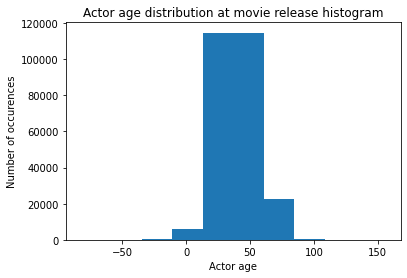

In [10]:
plt.hist(characterDF['Actor age at movie release'].dropna())
plt.title("Actor age distribution at movie release histogram")
plt.xlabel("Actor age")
plt.ylabel("Number of occurences")
plt.show()

In these histograms, we clearly see that age distribution is biased : the most of the actor are between $20$ and $50$ year old when acting. To assign a good score to movies where young and old actors play, we choose to give a weight of 1 for age ranges between 20 an 50, and a weight of $5$ for the other. In this way, a movie where young and old people are rather well represented will get a higher score.

To set the scoring function, since in reality each age ranges includes about $7\%$ of the whole population, we want a resolution that assigns a very good score to a difference of less than $5\%$ and a very bad score if the difference is greater than $10\%$ from movie to reality.

With the same process than before, good values are found for $p=1.5$ and $\sigma=5$.

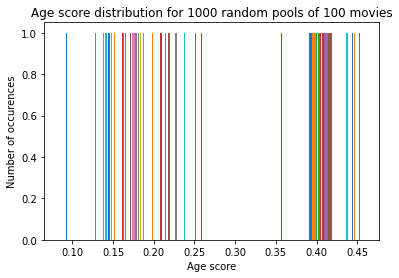

The max score is (0.46173043374609596, 0.14) and the min is (0.3746420122400446, 0.18).


In [13]:
#Test on a large number of random pools of 100 rows each.
scores_list=[]
for i in range(Ntest):
    P=characterDF.sample(n=100)
    scores_list.append(age_score(P))
    
plt.hist(scores_list)
plt.title(f"Age score distribution for {Ntest} random pools of 100 movies")
plt.xlabel("Age score")
plt.ylabel("Number of occurences")
plt.show()
print(f"The max score is {max(scores_list)} and the min is {min(scores_list)}.")

In [ ]:
print()

Here we see that the scoring is not relevant enough, since all values are between 0.35 and 0.55.
We tried a lot of tricks to improve this, but here is the most efficient scoring we could reach.
However, it is still possible to spread the score between 0 and 1, by normalizing the gaussian obtained with a min-max strategy.

For this, we considered the scores to mainly stay in the range $[0.30,0.60]$ (see histogram), and we applied the min/max normalization for the rescue. We are trying to understand if this is 

In [12]:
#Test on a large number of random pools of 100 rows each.
rescued_scores_list=[]

for i in range(Ntest):
    P=characterDF.sample(n=100)
    rescued_scores_list.append(rescued_age_score(P))
    
plt.hist(rescued_scores_list)
plt.title(f"Rescued score distribution for {Ntest} random pools of 100 movies")
plt.xlabel("Rescued age score")
plt.ylabel("Number of occurences")
plt.show()
print(f"The max score is {max(rescued_scores_list)} and the min is {min(rescued_scores_list)}.")

TypeError: unsupported operand type(s) for -: 'tuple' and 'float'

##### Height score tests

In [ ]:
#Test on a large number of random pools of 100 rows each.
scores_list=[]
for i in range(Ntest):
    #P=random_movie_pool()
    P=characterDF.sample(n=100)
    scores_list.append(height_score(P))
    
plt.hist(scores_list)
plt.title(f"Height score distribution for {Ntest} random pools of 100 rows")
plt.xlabel("Height score")
plt.ylabel("Number of occurences")
plt.show()
print(f"The max score is {max(scores_list)} and the min is {min(scores_list)}.")

In [ ]:
#Test on a large number of random pools of 100 rows each.
rescued_scores_list=[]

for i in range(Ntest):
    P=characterDF.sample(n=100)
    rescued_scores_list.append(rescued_height_score(P))
    
plt.hist(rescued_scores_list)
plt.title(f"Rescued score distribution for {Ntest} random pools of 100 movies")
plt.xlabel("Rescued age score")
plt.ylabel("Number of occurences")
plt.show()
print(f"The max score is {max(rescued_scores_list)} and the min is {min(rescued_scores_list)}.")

#### Ethnicity score

In [ ]:
#Test on a large number of random pools of 100 rows each.
scores_list=[]
for i in range(Ntest):
    P=characterDF.sample(n=100)
    scores_list.append(diversity_score(P))
    
plt.hist(scores_list)
plt.title(f"Age score distribution for {Ntest} random pools of 100 movies")
plt.xlabel("Age score")
plt.ylabel("Number of occurences")
plt.show()
print(f"The max score is {max(scores_list)} and the min is {min(scores_list)}.")

#### Representativeness assessment

In [ ]:
#Test on a large number of random pools of 100 rows each.
scores_list=[]
for i in range(Ntest):
    P=characterDF.sample(n=100)
    scores_list.append(representativeness_score(P))
    
plt.hist(scores_list)
plt.title(f"Overall score distribution for {Ntest} random pools of 100 movies")
plt.xlabel("Overall score")
plt.ylabel("Number of occurences")
plt.show()
print(f"The max score is {max(scores_list)} and the min is {min(scores_list)}.")

In [ ]:
def random_movie_pool(n=100):
    """
    Extract the actors of 100 random movies.
    """
    movie_list = np.random.choice(characterDF['Wikipedia movie ID'].unique(), size=n, replace=False)
    pool = characterDF[characterDF['Wikipedia movie ID'].isin(movie_list)]
    return pool
    